In [1]:
# Load Extension for noTeXbook theme
%load_ext notexbook

In [2]:
# Enable noTeXbook theme
%texify

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/pytorch-beautiful-ml-data/pydata-global?filepath=5_case_study/extra_patching_batches.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/pytorch-beautiful-ml-data/blob/pydata-global/5_case_study/extra_patching_batches.ipynb)
</span>

<span class="fn"><i>[Note]: </i> This notebook has been designed using the [$\text{no}\TeX\text{book}$](https://github.com/leriomaggio/notexbook-jupyter-theme) Jupyter notebook theme. 
Please **trust** the notebook to enable the theme, or **run the two cells above** $\Uparrow$.</span>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Setup-environment" data-toc-modified-id="Setup-environment-0.1">Setup environment</a></span><ul class="toc-item"><li><span><a href="#Data-directory" data-toc-modified-id="Data-directory-0.1.1">Data directory</a></span></li></ul></li></ul></li><li><span><a href="#Download-dataset" data-toc-modified-id="Download-dataset-1">Download dataset</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Set-MSD-Spleen-dataset-path" data-toc-modified-id="Set-MSD-Spleen-dataset-path-1.0.1">Set MSD Spleen dataset path</a></span></li><li><span><a href="#Set-deterministic-training-for-reproducibility" data-toc-modified-id="Set-deterministic-training-for-reproducibility-1.0.2">Set deterministic training for reproducibility</a></span></li></ul></li><li><span><a href="#Setup-transforms-for-training-and-validation" data-toc-modified-id="Setup-transforms-for-training-and-validation-1.1">Setup transforms for training and validation</a></span><ul class="toc-item"><li><span><a href="#Check-transforms-in-DataLoader" data-toc-modified-id="Check-transforms-in-DataLoader-1.1.1">Check transforms in DataLoader</a></span></li><li><span><a href="#Define-CacheDataset-and-DataLoader-for-training-and-validation" data-toc-modified-id="Define-CacheDataset-and-DataLoader-for-training-and-validation-1.1.2">Define CacheDataset and DataLoader for training and validation</a></span></li></ul></li></ul></li></ul></div>

⚠️ This notebook is quite demanding in terms of computation resources. I would encourage opening this notebook on Colab (at least) for better performance.

# Random Tiling for Spleen Segmentation

This tutorial shows how to process _patches_ into DL batches as extracted using MONAI
Random transformers.

The original version of this notebook can be found [here](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb).

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

### Setup environment

Extra Deps.

In [1]:
%pip install -qU "monai[gdown, nibabel]"

In [2]:
!pip install -qU tqdm

In [3]:
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first, set_determinism

print_config()

MONAI version: 0.3.0
Python version: 3.6.9 (default, Oct  8 2020, 12:12:24)  [GCC 8.4.0]
OS version: Linux (4.19.112+)
Numpy version: 1.18.5
Pytorch version: 1.7.0+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.0.0
Tensorboard version: 2.3.0
gdown version: 3.6.4
TorchVision version: 0.8.1+cu101
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.51.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
%matplotlib inline

#### Data directory

In [5]:
import os

directory = "./MONAI_DATA_DIRECTORY"
os.makedirs(directory, exist_ok=True)

## Download dataset

Downloads and extracts the dataset. The dataset comes from [http://medicaldecathlon.com/](http://medicaldecathlon.com/).

In [6]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(directory, "Task09_Spleen.tar")
data_dir = os.path.join(directory, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, directory, md5)

#### Set MSD Spleen dataset path

In [7]:
import glob

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

#### Set deterministic training for reproducibility

In [8]:
set_determinism(seed=0)

### Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadNiftid` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `ToTensord` converts the numpy array to PyTorch Tensor for further steps.

In [9]:
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

In [10]:
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # THIS WILL RETURN PATCHES 
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=50,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
        #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

#### Check transforms in DataLoader

In [11]:
from monai.data import CacheDataset, DataLoader, Dataset

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


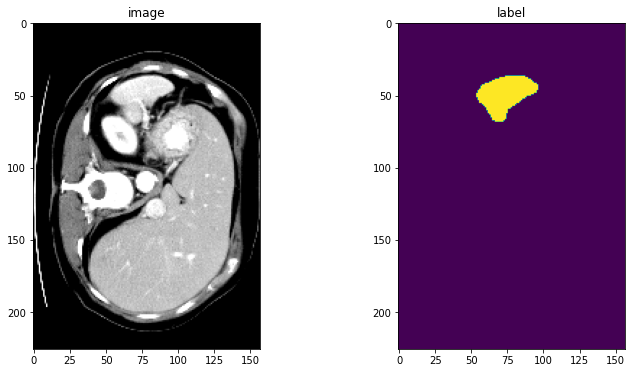

In [12]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

#### Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [14]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, 
                        cache_rate=1.0, num_workers=4)

Load and cache transformed data: 100%|██████████| 32/32 [01:20<00:00,  2.51s/it]


In [15]:
sample = train_ds[0]

In [16]:
len(sample)

50

In [17]:
type(sample)

list

In [18]:
sample[0].keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict'])

In [19]:
sample[0]['image'].shape

torch.Size([1, 96, 96, 96])

In [20]:
image = sample[0]['image'][0]

In [21]:
image.shape

torch.Size([96, 96, 96])

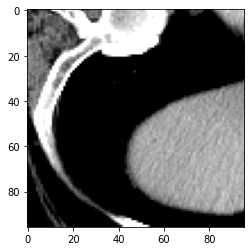

In [22]:
plt.imshow(image[:, :, 80], cmap="gray")
plt.show()

In [23]:
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

In [24]:
loader_iter = iter(train_loader)

In [25]:
batch = next(loader_iter)

In [26]:
batch['image'].shape

torch.Size([100, 1, 96, 96, 96])

In [27]:
from torch.utils.data import BatchSampler

In [28]:
images, labels = batch['image'], batch['label']

In [29]:
images.shape, labels.shape

(torch.Size([100, 1, 96, 96, 96]), torch.Size([100, 1, 96, 96, 96]))

In [30]:
pairs = iter(zip(BatchSampler(images, batch_size=2, drop_last=False),
                 BatchSampler(labels, batch_size=2, drop_last=False)))

In [31]:
pair = next(pairs)

In [32]:
images_batch, labels_batch = pair

In [33]:
type(images_batch), type(images_batch[0])

(list, torch.Tensor)

In [34]:
from monai.data.utils import list_data_collate

In [35]:
images_batch_tensor = list_data_collate(images_batch)

In [36]:
images_batch_tensor.shape

torch.Size([2, 1, 96, 96, 96])

In [37]:
from typing import Sequence, Any, Optional
from monai.data.utils import list_data_collate
from torch.utils.data import BatchSampler


class PatchSampler(BatchSampler):

    def __init__(self, patches: Sequence[Any], 
                 targets : Optional[Sequence[Any]] = None,
                 num_patches: int = 1, 
                 drop_last: bool = False) -> None:
        
        if targets is not None:
            sampler = zip(patches, targets)
        else:
            sampler = patches
        super(PatchSampler, self).__init__(sampler=sampler, 
                                           batch_size=num_patches,
                                           drop_last=drop_last)
        
    def __iter__(self):
        patches = super(PatchSampler, self).__iter__()
        for patch in patches:
            yield list_data_collate(patch)

In [38]:
train_loader = DataLoader(train_ds, batch_size=3, shuffle=True, num_workers=0)

In [39]:
for i, batch in enumerate(train_loader):
    print(f'Batch {i+1}: ', end="")
    images, labels = batch["image"], batch["label"]
    print(f"Images: {images.shape} - Labels: {labels.shape}")
    print("-"*10)
    patches = PatchSampler(images, labels, num_patches=32, drop_last=False)
    for j, (img_patches, segmentations) in enumerate(patches):
        print(f"Mini-Batch {j+1:01}: ", end="")
        print(f"Images-mini-batch: {img_patches.shape}", end=" - ")
        print(f"Labels-mini-batch: {segmentations.shape}")
    print("-"*10)
    if i == 2:
        break

Batch 1: Images: torch.Size([150, 1, 96, 96, 96]) - Labels: torch.Size([150, 1, 96, 96, 96])
----------
Mini-Batch 1: Images-mini-batch: torch.Size([32, 1, 96, 96, 96]) - Labels-mini-batch: torch.Size([32, 1, 96, 96, 96])
Mini-Batch 2: Images-mini-batch: torch.Size([32, 1, 96, 96, 96]) - Labels-mini-batch: torch.Size([32, 1, 96, 96, 96])
Mini-Batch 3: Images-mini-batch: torch.Size([32, 1, 96, 96, 96]) - Labels-mini-batch: torch.Size([32, 1, 96, 96, 96])
Mini-Batch 4: Images-mini-batch: torch.Size([32, 1, 96, 96, 96]) - Labels-mini-batch: torch.Size([32, 1, 96, 96, 96])
Mini-Batch 5: Images-mini-batch: torch.Size([22, 1, 96, 96, 96]) - Labels-mini-batch: torch.Size([22, 1, 96, 96, 96])
----------
Batch 2: Images: torch.Size([150, 1, 96, 96, 96]) - Labels: torch.Size([150, 1, 96, 96, 96])
----------
Mini-Batch 1: Images-mini-batch: torch.Size([32, 1, 96, 96, 96]) - Labels-mini-batch: torch.Size([32, 1, 96, 96, 96])
Mini-Batch 2: Images-mini-batch: torch.Size([32, 1, 96, 96, 96]) - Labels